# Exam questions and solutions

## 1. Numerical derivatives with complex numbers

**Question:** In class we derived finite difference approximations to the derivative of a function using Taylor expansions. An alternative way to do this is to take an *imaginary* step $x\rightarrow x+ih$ away from the point $x$ (assumed real), where $h\ll 1$ is the step size. Then the Taylor expansion is

$$f(x + ih) \approx f(x) + ih \left.{df\over dx}\right|_x +\cdots,$$

and taking the imaginary part of the equation gives the derivative as 

$$\Rightarrow {df\over dx} \approx {\mathrm{Im} \left[f(x + ih)\right]\over h}.$$

(a) Write a Python function that uses the complex variables available in Python to implement this approximation for $df/dx$. Your Python function should be defined as
```
def deriv(func, x, h)
```
where the parameters are `func`, the function $f(x)$ to be differentiated, `x`, the $x$ value where the derivative will be calculated, and `h`, the step-size. You should return the numerical value of the derivative. For example, if you wanted the derivative of $\sin(x)$ at $x=1$ with step-size $10^{-4}$ you could use
```
dfdx = deriv(np.sin, 1, 1e-4)
```

(b) Use your function to evaluate the derivative of $\sin^3 x$ at $x=1.5$ as a function of $h$. Do the same using a centered finite difference derivative. Plot the fractional error (compared to the analytic answer) as a function of step size $h$ for both methods on the same plot. Discuss your results and explain the behaviour you see. How do you explain the differences between the two curves?

**Solution:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.integrate import solve_ivp, simpson

(a) We need to implement

$${df\over dx} = {\mathrm{Im} \left[f(x + ih)\right]\over h}$$

In [2]:
def deriv(func, x, h):
    y = x + 1J*h
    return np.imag(func(y))/h

In [3]:
# try the example given in the question
print(deriv(np.sin, 1, 1e-4))
print(np.cos(1))

0.5403023067686435
0.5403023058681398


(b) Now we need to compute the derivative given in the question for different step sizes $h$ and also compare to the centered difference derivative.

In [4]:
def deriv_centered(func, x, h):
    # second order finite difference
    return (func(x+h) - func(x-h)) / (2*h)

1e-12 0.21114975082386198 1.3144971996098735e-16 0.21110890813247352 0.00019342997673012772
3.1622776601683794e-12 0.21114975082386198 1.3144971996098735e-16 0.21115907896754568 4.417785788208612e-05
1e-11 0.21114975082386195 0.0 0.21115331705345852 1.6889575207452053e-05
3.1622776601683794e-11 0.21114975082386198 1.3144971996098735e-16 0.21114679105040565 1.4017413919492775e-05
1e-10 0.21114975082386195 0.0 0.21114998638438465 1.115608812133569e-06
3.1622776601683795e-10 0.21114975082386195 0.0 0.2111495997171805 7.156375077671606e-07
1e-09 0.21114975082386198 1.3144971996098735e-16 0.2111497088286285 1.9888838747630465e-07
3.1622776601683795e-09 0.21114975082386192 1.3144971996098735e-16 0.2111497577046866 3.258741548688466e-08
1e-08 0.211149750823862 2.628994399219747e-16 0.21114974213531923 4.1148723523119814e-08
3.162277660168379e-08 0.2111497508238622 1.1830474796488863e-15 0.21114974892760294 8.980635797703979e-09
1e-07 0.21114975082386445 1.1830474796488862e-14 0.21114975046199

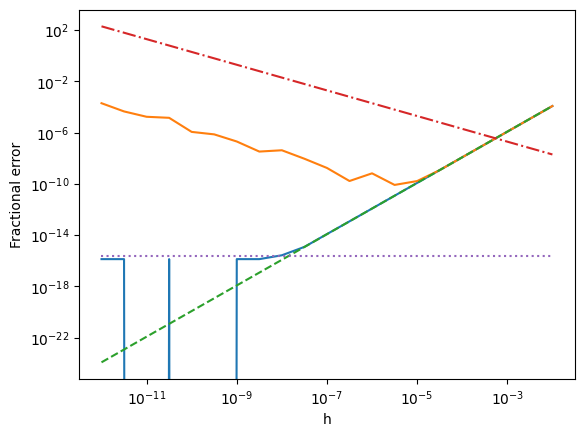

In [5]:
hvals = 10**np.linspace(-12,-2,21)

def func(x):
    return np.sin(x)**3
f = func
x = 1.5
true_value = 3*np.sin(x)**2*np.cos(x)

err1 = np.array([])
err2 = np.array([])
for h in hvals:
    err1 = np.append(err1, abs(deriv(f, x, h)-true_value)/true_value)
    err2 = np.append(err2, abs(deriv_centered(f, x, h)-true_value)/true_value)
    print(h, deriv(f, x, h), abs(deriv(f, x, h)-true_value)/true_value, deriv_centered(f, x, h), 
          abs(deriv_centered(f, x, h)-true_value)/true_value)

plt.plot(hvals, err1)
plt.plot(hvals, err2)
plt.plot(hvals, err1[-1]*hvals**2/hvals[-1]**2, "--")
plt.plot(hvals, err2[0]*hvals**-1/hvals[0]**-0.5, "-.")
# Plot the roundoff error
plt.plot([min(hvals), max(hvals)], [2.2e-16]*2, ":")
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Fractional error')
plt.xlabel('h')
plt.show()

Discussion of results:

- For the larger step sizes, both methods scale like $h^2$ and follow the same curve (green dashed line). We expect from the class notes that the centered finite difference derivative should be 2nd order. In the complex derivative, the first term that is dropped is actually first order (because it is $\propto h^2 d^2f/dx^2$ and then we divide by $h$), but that term is real so it drops out when we take the imaginary part. The first correction term to the imaginary part is the $d^3f/dx^3$ term which is $\propto h^2$.

- The behavior at small $h$ is different for the two methods:

    * In the case of the finite-difference derivative, we see that there is a minimum error at $h\sim 10^{-5}$. The error increases $\propto 1/h$ for smaller step sizes which agrees with our estimate for the round-off error term from class. Because we have a second order derivative, the optimum step size is $\sim (10^{-16})^{1/3}\sim 10^{-5}$ rather than $(10^{-16})^{1/2}$ which we had for the first order derivative in class.
    *  The complex derivative behaves differently. It follows the $h^2$ scaling all the way to the round-off limit. This difference arises because we don't have to do a subtraction in the complex method; the accuracy is determined only by how well we can evaluate the function which is limited only by the machine precision.

## 2. Solution of the Schrödinger equation

**Question:** Solve the time-independent Schrödinger equation

$$-{\hbar^2\over 2m} {d^2\Psi\over dx^2} + V(x)\Psi = E\Psi,$$ 

for a particle moving in the 1D potential 

$$V(x) = - \exp\left(-\sqrt{|x|}\right)$$ 

($-\infty<x<\infty$). Plot the ground state wavefunction $\Psi_0(x)$ and obtain a numerical value for the energy of the ground state that is accurate to at least 1 part in 1000. (You should demonstrate this by obtaining a numerical estimate of the energy error.)

**Solution:** We can solve this as an eigenvalue problem similar to the wave on a string from homework 6.

Finite-difference the time-independent Schrodinger equation, setting $\hbar^2/2m=1$ for simplicity (which means when we get a value for energy it is actually $2mE/\hbar^2$):

$$-{\hbar^2\over 2m} {d^2f\over dx^2} + V(x)f = Ef$$

$${d^2f\over dx^2} + (E-V)f = 0$$

$${f_{i+1}-2f_i+f_{i-1}\over h^2} = -(E-V_i)f_i$$

$$-f_{i+1}+(2+h^2V_i)f_i-f_{i-1} = h^2Ef_i$$

Bound state energy =  -0.30208132150693195
Bound state energy =  -0.057976526335251806
Bound state energy =  -0.021032517563107693


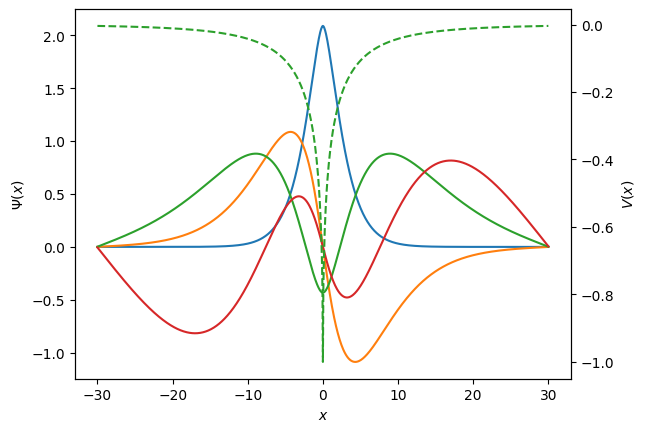

In [34]:
n = 1001
x = np.linspace(-30,30,n)
h = x[1]-x[0]
V = - np.exp(-np.sqrt(np.abs(x)))

# Construct the matrix and solve for the first 4 eigenvalues and eigenvectors
A = np.diag(2*np.ones(n) + h**2*V, k=0) + np.diag(-np.ones(n-1),k=-1) + np.diag(-np.ones(n-1),k=1)
E, f = scipy.linalg.eigh(A, subset_by_index=(0,3))

E = E/h**2
for EE in E:
    if EE<0:
        print("Bound state energy = ", EE)

fig, ax1 = plt.subplots()
for i in range(len(E)):
    norm = scipy.integrate.simpson(f[:,i]**2,x)
    plt.plot(x, f[:, i]/norm)
ax1.set_ylabel(r'$\Psi(x)$')
#plt.plot(x, np.exp(-np.abs(x)*np.sqrt(-2*E[0])),"--")
ax2 = ax1.twinx()
plt.plot(x, V, "C2--")
ax2.set_ylabel(r'$V(x)$')
ax1.set_xlabel(r'$x$')
plt.show()

We see that there are three bound states, the lowest energy is approximately -0.3.

(Note that a different choice of units would give a different value, e.g. setting $\hbar^2/m=1$ above and keeping the factor of 2 gives $E\approx -0.357$).

To assess the error, we can check how the energy depends on increasing the number of grid points used and also the +- endpoints for x. 

In [7]:
nvals = (1000,2000,4000)
xvals = (10,20,40)

Earr = np.zeros((len(nvals), len(xvals)))

for i, n1 in enumerate(nvals):
    for j, x0 in enumerate(xvals):
        n = int(n1 * x0/20) + 1
        x = np.linspace(-x0,x0,n)
        h = x[1]-x[0]
        V = - np.exp(-np.sqrt(np.abs(x)))
        A = np.diag(2*np.ones(n) + h**2*V, k=0) + np.diag(-np.ones(n-1),k=-1) + np.diag(-np.ones(n-1),k=1)
        E = scipy.linalg.eigh(A, subset_by_index=(0,0), eigvals_only=True)   # we only need the first eigenvalue
        E = E/h**2
        print(n1, x0, n, "E=", E[0])

1000 10 501 E= -0.3012749968924646
1000 20 1001 E= -0.3013895769195456
1000 40 2001 E= -0.3013895799235332
2000 10 1001 E= -0.3007330266811587
2000 20 2001 E= -0.3008510003502323
2000 40 4001 E= -0.300851003477853
4000 10 2001 E= -0.3005391726696906
4000 20 4001 E= -0.300658728177554
4000 40 8001 E= -0.30065873135955395


We see that we converge to 1 part in 1000. The energy is $E\approx -0.3007$.

There were also some nice solutions to this problem using a shooting method. Since the potential is symmetric, you can start at $x=0$ and integrate outwards to some $x=L$, choosing $E$ so that $\Psi$ vanishes there. Changing $L$ and checking the convergence of $E$ then gives an error estimate.

# 3. Thermal diffusion equation

**Question:** A thin slab of material cools from its surface. The horizontal dimensions of the slab are much larger than its thickness, so we can follow the cooling using the 1D thermal diffusion equation 

$${\partial T\over \partial t} = \kappa{\partial^2 T\over \partial x^2},$$

where $\kappa$ is the thermal diffusivity. In this particular sample of material, the thermal diffusivity is non-uniform. The data file at https://github.com/andrewcumming/phys512/blob/main/final_data.txt gives some measurements of the thermal diffusivity in units of $\mathrm{cm^2/s}$ as a function of height $x$ in the slab, from $x=0$ (base of the slab) to $x=1$ cm (top of the slab). (In the file, column 1 is the $x$ position and column 2 is the measured value of $\kappa$.)

The slab is initially at $T=100$K everywhere, and at $t=0$ the surface of the slab at $x=1$ is suddenly cooled to $T=0$K and held at that temperature. The base of the slab at $x=0$ is insulating.

Calculate the temperature at the base of the slab at $t=1$ second.

**Solution:** The differenced equation is

$${dT_i\over dt} = {K_i\over h^2} \left(T_{i+1}-2T_i+T_{i-1}\right)$$

Implicit time-differencing gives

$$T_i^{n+1} - T_i^n = {K_i\Delta t\over h^2} \left(T^{n+1}_{i+1}-2T^{n+1}_i+T^{n+1}_{i-1}\right)$$

Defining $\alpha_i = K_i\Delta t/h^2$, this gives

$$- \alpha_i T^{n+1}_{i-1}+ T_i^{n+1}(1 + 2\alpha_i) - \alpha_i T^{n+1}_{i+1}  = T_i^n $$

very similar to before, we just need to make sure we put the correct values of $\alpha$ in each position of the matrix.


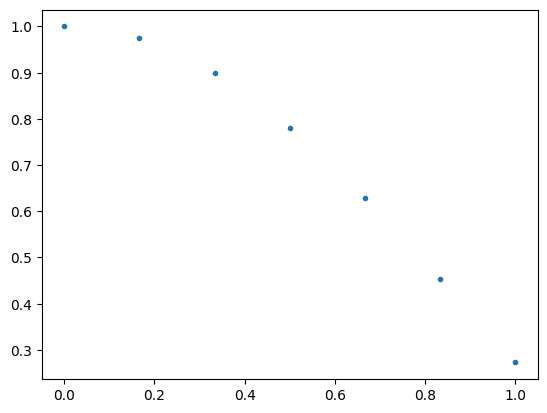

In [8]:
# This is how I generated the data for K(x): 
x = np.linspace(0,1,7)
func = lambda x: np.cos(np.pi * 0.38 * x)**1.3
f = func(x)
plt.plot(x,f,".")
plt.show()
np.savetxt('data.txt', np.column_stack((x,f)))

n= 1000  dt= 0.01  max alpha= 9980.051923381965


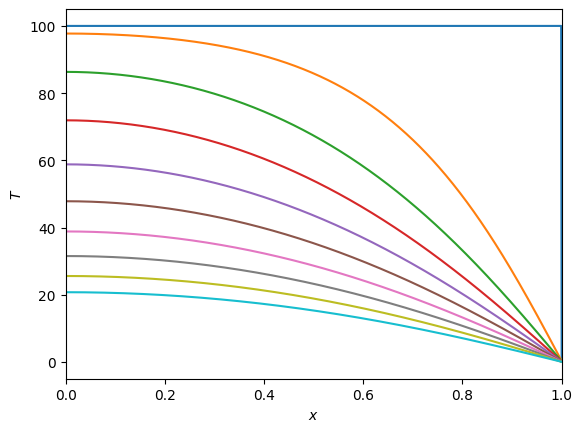

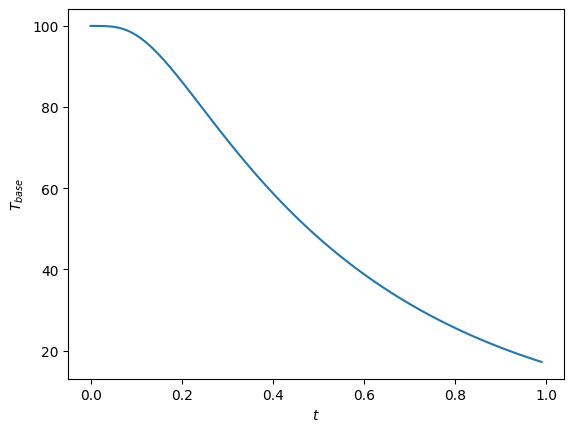

T base at 1 second =  17.192220533238743


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

def do_int(n, dt, show_plots=False, interp='Spline'):
    x = np.linspace(0, 1, n)

    # Initial profile has T=1 everywhere except T=0 at the outer boundary
    T = 100 * np.ones(n)
    #T = 100 * np.cos(np.pi/2 * x)
    T[-1] = 0.0

    if show_plots:
        plt.plot(x, T)
        plt.xlabel(r'$x$')
        plt.ylabel(r'$T$')

    # read in K from the file
    xp, Kp = np.loadtxt('data.txt', unpack=True)
    if interp == 'Spline':
        Kinterp = scipy.interpolate.CubicSpline(xp,Kp)
        K = Kinterp(x)
    else:
        K = np.interp(x,xp,Kp)  # linear interpolation
    dx = x[1]-x[0]
    alpha = K * dt/dx**2     # alpha here depends on position
    print("n=", n, " dt=", dt, " max alpha=", np.max(alpha))
    nsteps = int(1.0/dt)

    # Calculate the matrix A in banded form
    b = (1 + 2*alpha)
    b[0] = 1 + alpha[0] # insulating boundary at x=0
    a = np.zeros(n)
    c = np.zeros(n)
    c[:-1] = -alpha[1:]    # upper and lower diagonals need the right values of alpha
    a[1:] = -alpha[:-1]    # a is on the upper diagonal so needs to start with alpha_0, whereas c
                         # on the lower diagonal should start with alpha_1
    AA = np.row_stack((a,b,c))

    Tb = np.zeros(nsteps)
    Tb[0] = T[0]
    for i in range(1,nsteps):
        T = scipy.linalg.solve_banded((1,1), AA, T)
        Tb[i] = T[0]
        if show_plots:
            if (i % (nsteps//10) == 0):
                plt.plot(x, T)
    if show_plots:   
        plt.xlim((0,1))
        plt.show()
        plt.clf()
        plt.plot(np.arange(nsteps)*dt, Tb)
        plt.xlabel(r'$t$')
        plt.ylabel(r'$T_{base}$')
        plt.show()
    
    return Tb[-1]

Tb = do_int(1000, 1e-2, show_plots=True)
print("T base at 1 second = ", Tb)

In [10]:
# Check the convergence of the value with resolution and time-step:
print("T base at 1 second = ", do_int(300, 1e-2))
print("T base at 1 second = ", do_int(300, 1e-3))
print("T base at 1 second = ", do_int(300, 1e-4))
print("T base at 1 second = ", do_int(300, 1e-5))

print("T base at 1 second = ", do_int(1000, 1e-5))

# with linear interpolation instead of spline:
print("T base at 1 second = ", do_int(1000, 1e-5, interp='linear'))


n= 300  dt= 0.01  max alpha= 894.012366848957
T base at 1 second =  17.465150668266027
n= 300  dt= 0.001  max alpha= 89.4012366848957
T base at 1 second =  16.811908935338252
n= 300  dt= 0.0001  max alpha= 8.94012366848957
T base at 1 second =  16.747169685064893
n= 300  dt= 1e-05  max alpha= 0.8940123668489569
T base at 1 second =  16.74105253062163
n= 1000  dt= 1e-05  max alpha= 9.980051923381966
T base at 1 second =  16.4715221217201
n= 1000  dt= 1e-05  max alpha= 9.980010000000002
T base at 1 second =  16.59755790949586


Notes:
- It is important to get the $\alpha$-values correct in the matrix. A common error was to be off by one in the off-diagonals, which led to an inwards heat flux near the lower boundary (i.e. the maximum in temperature should be at $x=0$, not somewhere inside the grid!)
- The form of the thermal diffusion equation given in this problem is simplified. For a position-dependent $K$ it should actually be

$${\partial T\over \partial t} = {\partial\over\partial x}\left(K{\partial T\over \partial x}\right)$$

(try solving this form if you want an extra challenge...)

## 4. A power law from radioactive decays

**Question:** When two neutron stars merge, a mixture of many different radioactive elements is produced. The amount of each element decays with time according to 

$${dN\over dt} = -{N\over \tau}$$

where $N$ is the number of atoms of that element, and the decay timescale $\tau$ is different for each element. Assume that the decay timescales $\tau$ for these elements are randomly distributed between $10^3$ and $10^7$ seconds with a uniform distribution in $\log_{10}(\tau)$, and that 100 different elements are produced (with equal numbers of atoms of each initially). The total energy per second released by the radioactive decays is proportional to 

$$\sum_i {dN_i\over dt},$$

where the sum is over each element. Generate a random sample of 100 values of $\tau$ and integrate the decay of the 100 elements over time. Plot the total energy per second from radioactive decays over the first $10^6\ {\rm s}$. Do you agree with the prediction of Li \& Paczynski that the total energy per second is a power law, decaying $\propto 1/t$?


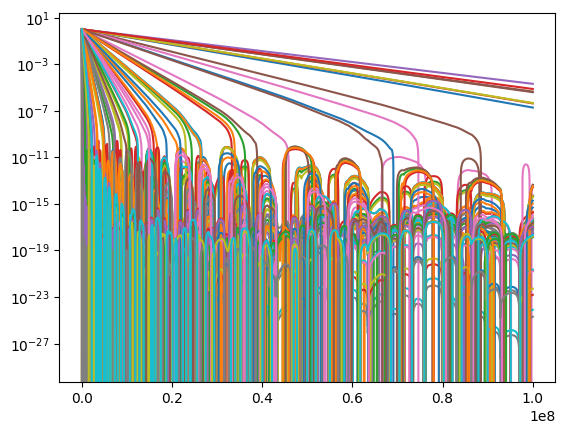

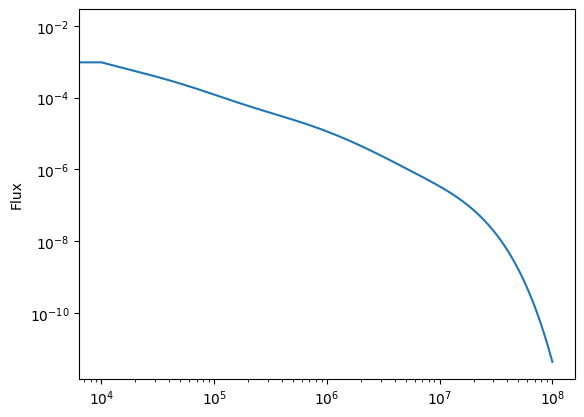

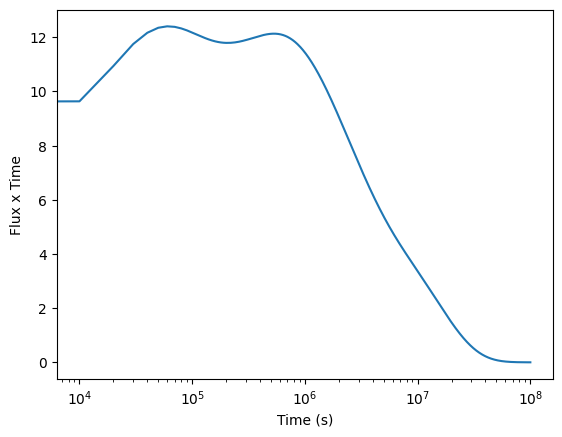

In [11]:
seed = 5885
rng = np.random.default_rng(seed)

def derivs(t, y, tau_vals):
    return -y / tau_vals

tau_vals = 3.0 + 4.0 * rng.uniform(size = 100)  # uniform in log between 1e3 and 1e7s
tau_vals = 10**tau_vals
y_init = np.ones_like(tau_vals)
t = np.linspace(0, 1e8, 10000)

# Integrate the equations using solve_ivp but you could also use the analytic solution if you wanted!
sol = solve_ivp(derivs, [t[0], t[-1]], y_init, t_eval = t, args = (tau_vals,), method = 'LSODA')
for i in range(len(tau_vals)):
    plt.plot(sol.t, sol.y[i])
plt.yscale('log')
plt.show()

flux = np.zeros_like(t)
for i in range(len(t)):
    flux[i] = np.sum(sol.y[:,i]/tau_vals)

plt.clf()
plt.plot(t, flux)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Flux')
plt.show()

plt.clf()
plt.plot(t, flux*t)
#plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Flux x Time')
plt.xscale('log')
plt.show()


Notes:
- the flux $\times$ time curve is approximately flat after we wait enough time (more than about a few times $10^3$ seconds) for multiple elements to start decaying. Before that nothing has decayed yet and the flux is constant at its initial value. The power law decay will end if we wait longer than the longest decay time (i.e.~longer than $10^7$ seconds).
- the intention in this question was to integrate the decay numerically for each species, but of course each one has a trivial analytic solution since the equations are not coupled, it was okay to use the analytic solution for $N(t)$ in your answer! Also there was a missing minus sign, the energy production rate is $\propto \sum (-dN/dt)$ since $dN/dt$ is negative.